In [8]:
import pandas as pd
from pandas import ExcelWriter
%matplotlib inline

In [17]:
from datetime import datetime 
import time 

btc_df = pd.read_csv('../data/BTC/BTC_2012-2018_1min.csv')
btc_df["Date(UTC)"] = pd.to_datetime(btc_df["Timestamp"], utc=True,unit='s')

google_trends_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_v2.csv', encoding='latin1')
google_trends_df["date"] = pd.to_datetime(google_trends_df["date"])
google_trends_df['Date(UTC)_trend'] = google_trends_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
google_trends_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_df.date]


display(btc_df.head())
display(btc_df.tail())
display(google_trends_df.head())
display(google_trends_df.tail())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC)
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:56:00


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC)
3273372,1522108560,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880,2018-03-26 23:56:00
3273373,1522108620,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788,2018-03-26 23:57:00
3273374,1522108680,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162,2018-03-26 23:58:00
3273375,1522108740,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837,2018-03-26 23:59:00
3273376,1522108800,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,2018-03-27 00:00:00


,date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date(UTC)_trend,Timestamp
0,2015-01-06 00:00:00,79,1,7,2,2,False,2015-01-06 05:00:00+00:00,1.420520e+09
1,2015-01-06 01:00:00,63,1,6,2,2,False,2015-01-06 06:00:00+00:00,1.420524e+09
2,2015-01-06 02:00:00,67,1,5,2,2,False,2015-01-06 07:00:00+00:00,1.420528e+09
3,2015-01-06 03:00:00,57,0,5,1,1,False,2015-01-06 08:00:00+00:00,1.420531e+09
4,2015-01-06 04:00:00,56,1,6,2,2,False,2015-01-06 09:00:00+00:00,1.420535e+09


,date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date(UTC)_trend,Timestamp
29755,2018-05-29 19:00:00,75,9,1,2,6,False,2018-05-30 00:00:00+00:00,1.527635e+09
29756,2018-05-29 20:00:00,77,9,1,1,6,False,2018-05-30 01:00:00+00:00,1.527638e+09
29757,2018-05-29 21:00:00,79,9,1,1,6,False,2018-05-30 02:00:00+00:00,1.527642e+09
29758,2018-05-29 22:00:00,76,9,1,2,7,False,2018-05-30 03:00:00+00:00,1.527646e+09
29759,2018-05-29 23:00:00,71,8,0,1,6,False,2018-05-30 04:00:00+00:00,1.527649e+09


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC),date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date(UTC)_trend
0,1420840800,289.59,289.94,289.13,289.13,34.042422,9854.490388,289.476771,2015-01-09 22:00:00,2015-01-09 17:00:00,53,0,6,1,1,False,2015-01-09 22:00:00+00:00
1,1420844400,293.61,293.61,292.15,292.15,36.628012,10733.474257,293.040042,2015-01-09 23:00:00,2015-01-09 18:00:00,52,0,7,1,1,False,2015-01-09 23:00:00+00:00
2,1420848000,293.89,293.89,293.89,293.89,0.158015,46.439149,293.890000,2015-01-10 00:00:00,2015-01-09 19:00:00,52,0,7,1,2,False,2015-01-10 00:00:00+00:00
3,1420851600,289.20,289.20,289.10,289.10,30.985828,8960.344674,289.175573,2015-01-10 01:00:00,2015-01-09 20:00:00,56,0,8,1,2,False,2015-01-10 01:00:00+00:00
4,1420855200,289.18,289.18,288.57,288.59,7.694195,2224.105007,289.062740,2015-01-10 02:00:00,2015-01-09 21:00:00,53,0,9,1,2,False,2015-01-10 02:00:00+00:00
5,1420858800,286.66,286.98,286.65,286.70,501.942237,143886.762160,286.660001,2015-01-10 03:00:00,2015-01-09 22:00:00,72,1,9,1,2,False,2015-01-10 03:00:00+00:00
6,1420862400,288.38,288.38,288.37,288.37,0.575908,166.078412,288.376527,2015-01-10 04:00:00,2015-01-09 23:00:00,62,0,8,1,2,False,2015-01-10 04:00:00+00:00
7,1420866000,290.25,290.66,290.25,290.27,2.315487,672.622449,290.488546,2015-01-10 05:00:00,2015-01-10 00:00:00,60,0,8,1,2,False,2015-01-10 05:00:00+00:00
8,1420869600,288.61,288.62,288.61,288.62,11.221734,3238.709911,288.610471,2015-01-10 06:00:00,2015-01-10 01:00:00,57,0,6,2,1,False,2015-01-10 06:00:00+00:00
9,1420873200,286.70,286.70,286.70,286.70,0.924500,265.054150,286.700000,2015-01-10 07:00:00,2015-01-10 02:00:00,59,0,7,2,1,False,2015-01-10 07:00:00+00:00


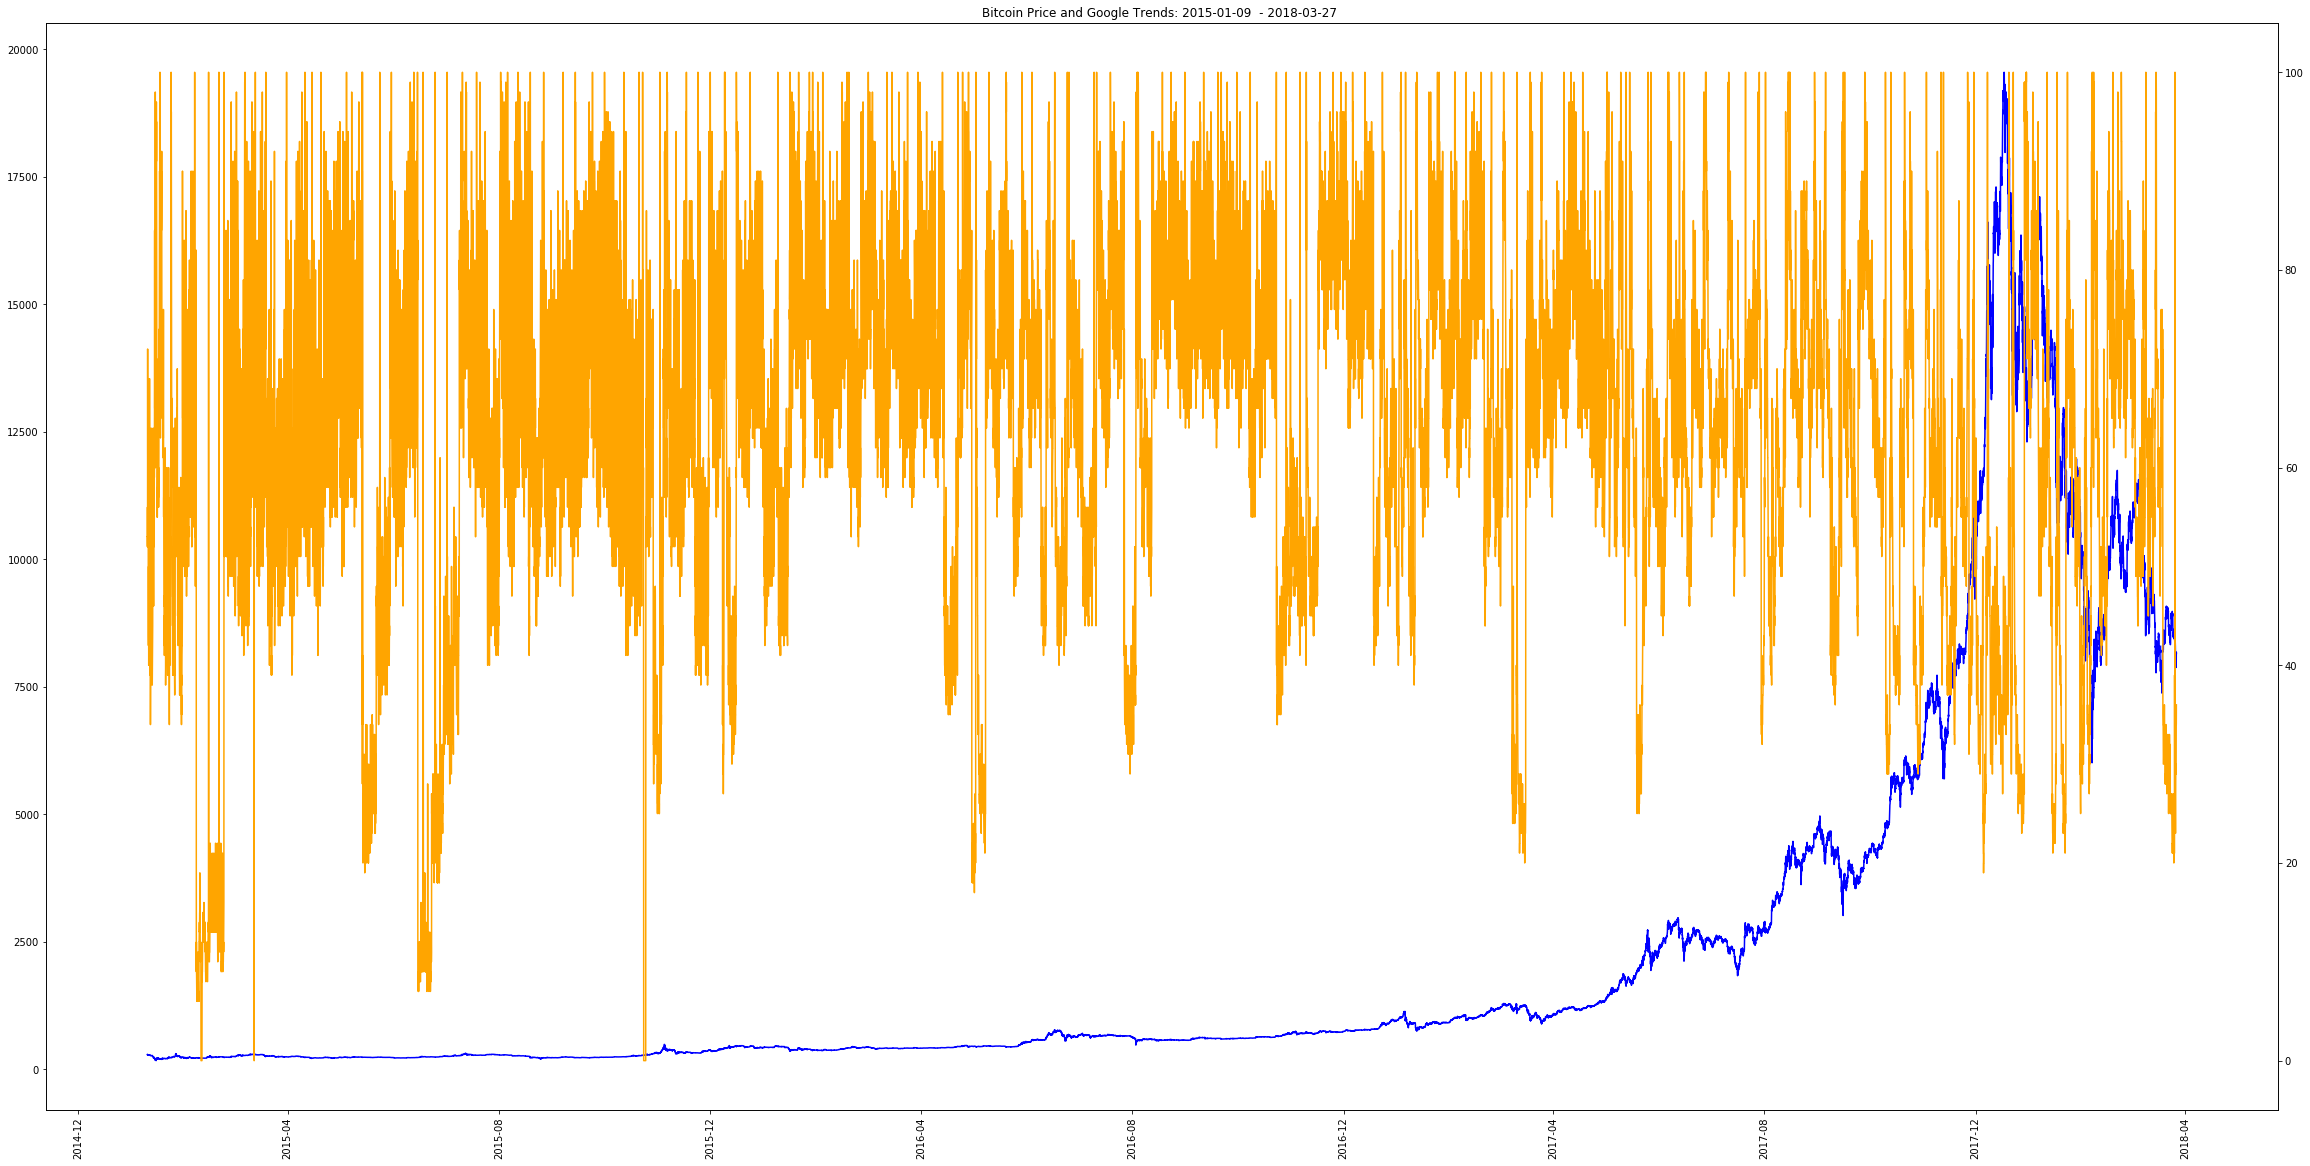

In [18]:
import matplotlib.pyplot as plt

btc_and_trends_df_hourly = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_df, right_on="Timestamp")
display(btc_and_trends_df_hourly)

fig_bitcoin_overall, ax_bitcoin_overall = plt.subplots(figsize=(40,20)) 
ax_bitcoin_overall.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Close"], color='blue')
ax_bitcoin_overall_2 = ax_bitcoin_overall.twinx() 
ax_bitcoin_overall_2.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Bitcoin"], color='orange' )
ax_bitcoin_overall.set_title('Bitcoin Price and Google Trends: ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overall.get_xticklabels():
    tick.set_rotation(90)
plt.show();


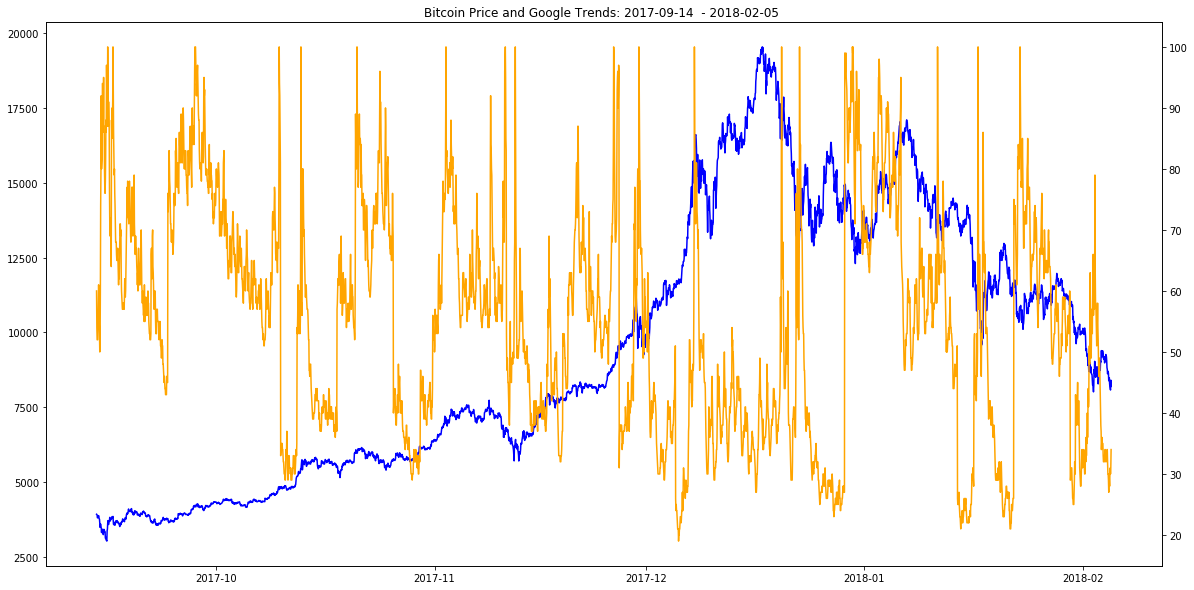

In [19]:
import matplotlib.pyplot as plt

# visualize Bitcoin's recent super spike starting Sep 2017 
sep_2017_to_feb_2018_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > 1505347200) & (btc_and_trends_df_hourly["Timestamp"] <=  1517788800) ]
#display(sep_2017_to_feb_2018_df)

fig_bitcoin_spike, ax_bitcoin_spike = plt.subplots(figsize=(20,10)) 
ax_bitcoin_spike.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Close"], color='blue')
ax_bitcoin_spike_2 = ax_bitcoin_spike.twinx() 
ax_bitcoin_spike_2.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Bitcoin"], color='orange' )
ax_bitcoin_spike.set_title('Bitcoin Price and Google Trends: ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overall.get_xticklabels():
    tick.set_rotation(90)
plt.show();

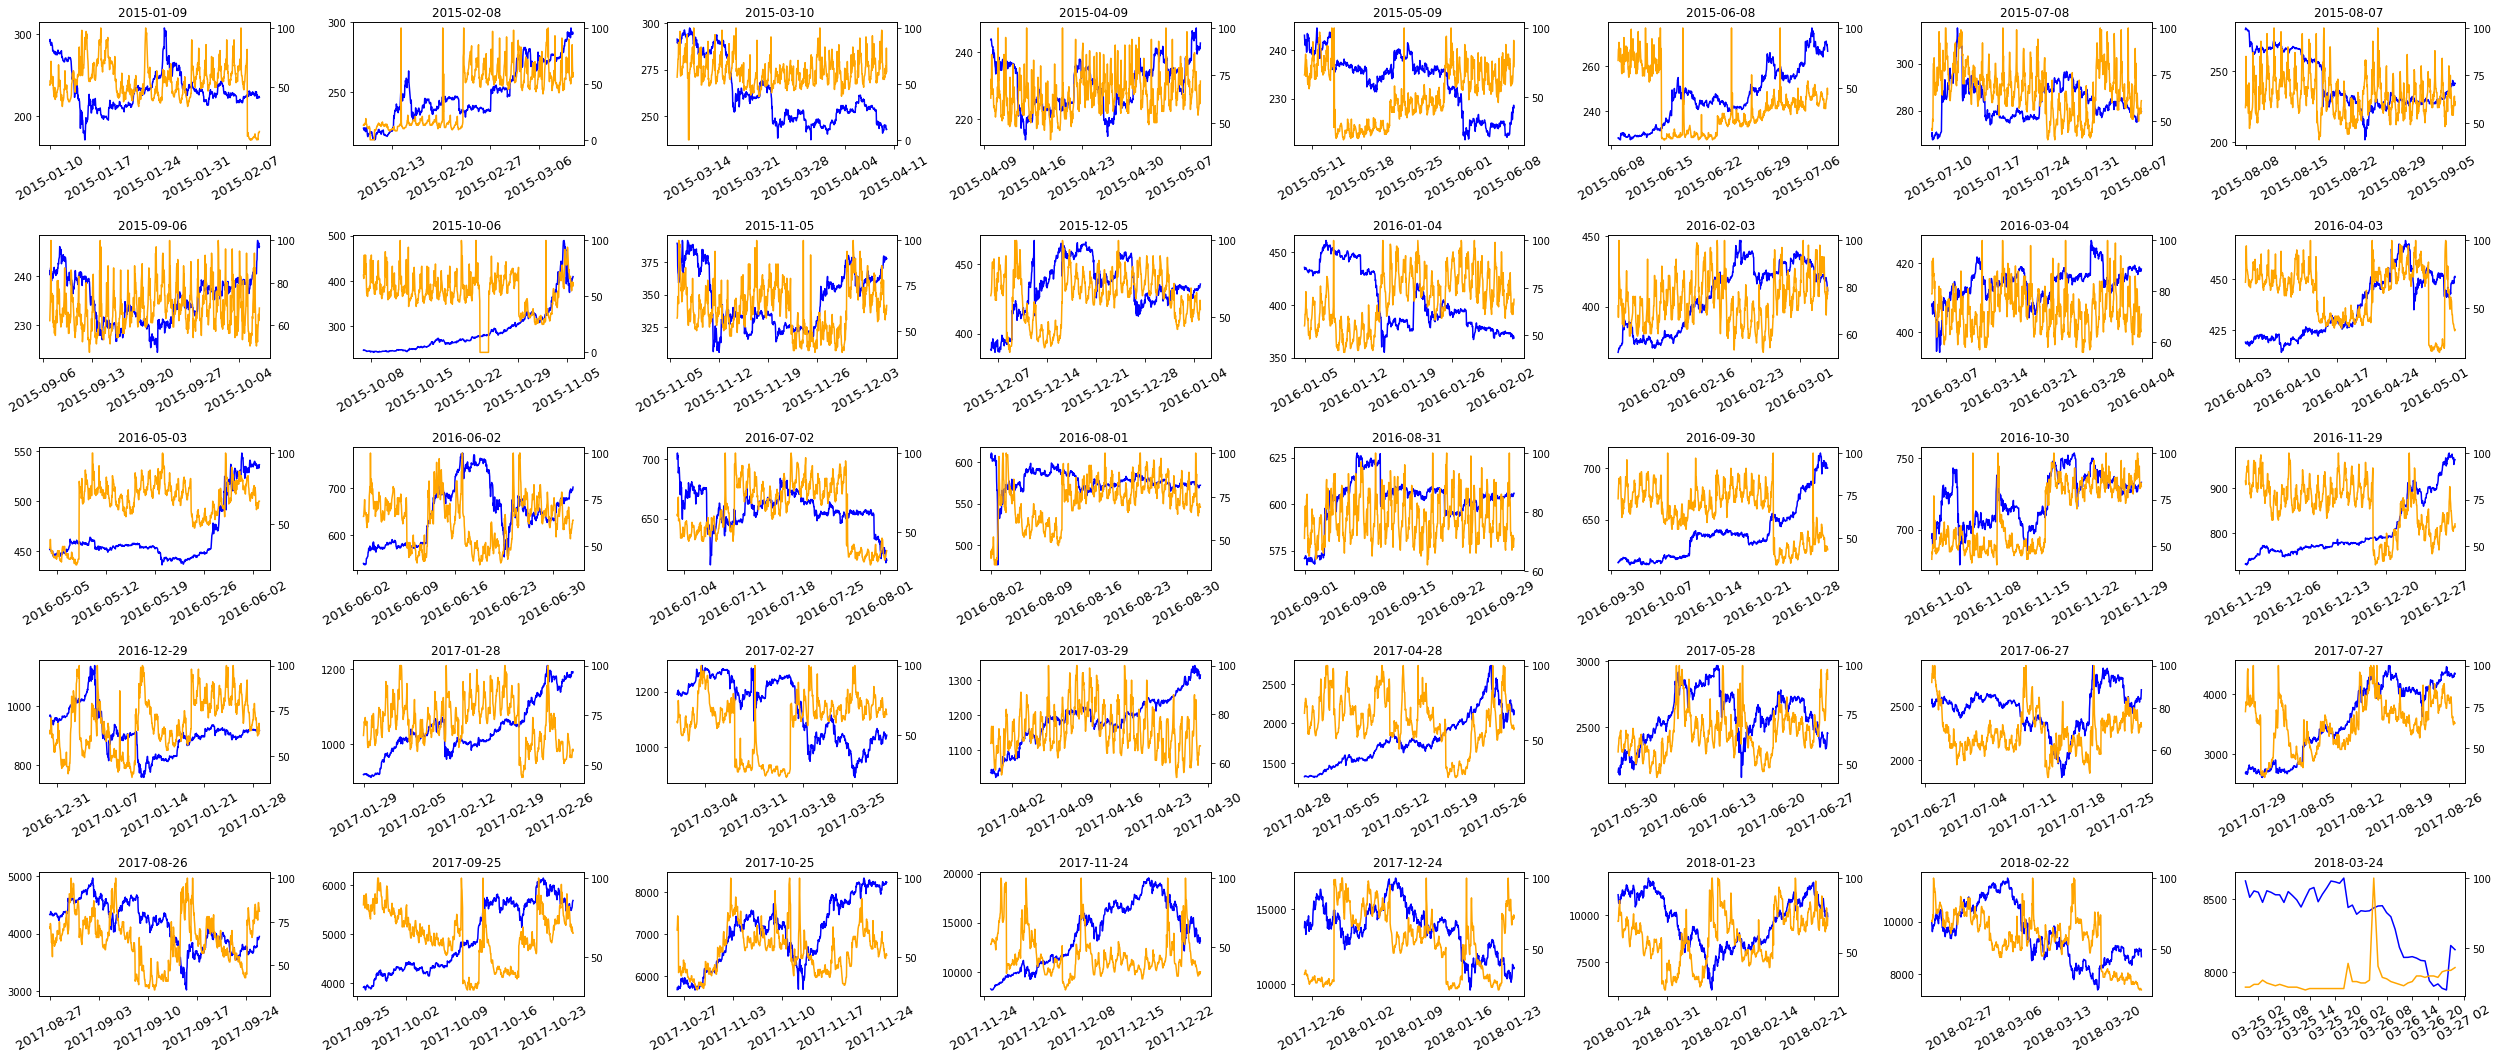

In [20]:
# from sklearn import preprocessing
# min_max_scaler=preprocessing.MinMaxScaler()

#change so that it just creates a new column

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = btc_and_trends_df_hourly[['Close','Bitcoin']]

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = min_max_scaler.fit_transform(btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']])
# btc_and_trends_df_hourly.head()

# fig, ax = plt.subplots()
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["close_normalized"])
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["bitcoin_normalized"])
# ax.set_title("Bitcoin Close Prices and Google Trends Normalized")
# ax.set(ylabel="price and trend, scaled to 0-1",xlabel="time")
# plt.show()

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(35,15), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin"], color='orange' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8])
    start_timestamp += 2592000
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
        tick.set_fontsize(13)
        
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     labels_modified = [label[5:] for label in labels] 
#     ax.set_xticklabels(labels_modified)
        
#         tick_label = tick.get_text()
#         display(tick_label)
#         tick.set_text(tick_label[5:]) Doesnt work!
    
plt.rcParams.update({'font.size': 16})
fig.tight_layout()
plt.show();

# Orange is Google Trends Hourly Data for the keyword 'Bitcoin'
# Blue is Bitcoin Hourly Close Data 

In [21]:
from luminol.anomaly_detector import AnomalyDetector 
from luminol.correlator import Correlator

# Convert dataframe into dictionary to put into luminol
timestamp_close_df = btc_and_trends_df_hourly[['Timestamp', 'Close']]
timestamp_bitcoin_trend_df = btc_and_trends_df_hourly[['Timestamp', 'Bitcoin']]
display(timestamp_close_df.head())
display(timestamp_bitcoin_trend_df.head())

timestamp_close_dict = timestamp_close_df.set_index('Timestamp')['Close'].to_dict()
timestamp_bitcoin_trend_dict = timestamp_bitcoin_trend_df.set_index('Timestamp')['Bitcoin'].to_dict()

# anomaly detector 
anomaly_detector = AnomalyDetector(timestamp_close_dict)
score = anomaly_detector.get_all_scores()

for timestamp, value in score.iteritems():
    # print anomaly score if greater than 0 
    if (value > 0 ):
        readable_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H')
        print(readable_date,'->', value)
    
# correlate Close price and Google Trends
anomalies = anomaly_detector.get_anomalies()
for anomaly in anomalies:
    time_period = anomaly.get_time_window()
    
    # to do: tweek the parameters for correlator (like the shift allowed)
    correlator = Correlator(timestamp_close_dict, timestamp_bitcoin_trend_dict, time_period)
    if correlator.is_correlated(threshold=0.5):
        print("Trend data correlate with Price at time period (%d, %d)" % time_period)



,Timestamp,Close
0,1420840800,289.13
1,1420844400,292.15
2,1420848000,293.89
3,1420851600,289.10
4,1420855200,288.59


,Timestamp,Bitcoin
0,1420840800,53
1,1420844400,52
2,1420848000,52
3,1420851600,56
4,1420855200,53


2017-10-04 03 -> 86.0
2017-10-04 04 -> 114.0
2017-10-04 05 -> 146.0
2017-10-04 06 -> 182.0
2017-10-04 07 -> 222.0
2017-10-04 08 -> 266.0
2017-10-04 09 -> 314.0
2017-10-04 10 -> 366.0
2017-10-04 11 -> 422.0
2017-10-04 12 -> 482.0
2017-10-04 13 -> 546.0
2017-10-04 14 -> 614.0
2017-10-04 15 -> 686.0
2017-10-04 16 -> 762.0
2017-10-04 17 -> 842.0
2017-10-04 18 -> 926.0
2017-10-04 19 -> 1014.0
2017-10-04 20 -> 1106.0
2017-10-04 21 -> 1202.0
2017-10-04 22 -> 1302.0
2017-10-04 23 -> 1406.0
2017-10-05 00 -> 1514.0
2017-10-05 01 -> 1626.0
2017-10-05 02 -> 1742.0
2017-10-05 03 -> 1862.0
2017-10-05 04 -> 1986.0
2017-10-05 05 -> 2114.0
2017-10-05 06 -> 2246.0
2017-10-05 07 -> 2382.0
2017-10-05 08 -> 2522.0
2017-10-05 09 -> 2666.0
2017-10-05 10 -> 2814.0
2017-10-05 11 -> 2966.0
2017-10-05 12 -> 3122.0
2017-10-05 13 -> 3282.0
2017-10-05 14 -> 3446.0
2017-10-05 15 -> 3614.0
2017-10-05 16 -> 3786.0
2017-10-05 17 -> 3962.0
2017-10-05 18 -> 4142.0
2017-10-05 19 -> 4326.0
2017-10-05 20 -> 4514.0
2017-10-0

2017-10-19 12 -> 1106.0
2017-10-19 13 -> 1014.0
2017-10-19 14 -> 926.0
2017-10-19 15 -> 842.0
2017-10-19 16 -> 762.0
2017-10-19 17 -> 686.0
2017-10-19 18 -> 614.0
2017-10-19 19 -> 546.0
2017-10-19 20 -> 482.0
2017-10-19 21 -> 422.0
2017-10-19 22 -> 366.0
2017-10-19 23 -> 314.0
2017-10-20 00 -> 266.0
2017-10-20 01 -> 222.0
2017-10-20 02 -> 182.0
2017-10-20 03 -> 146.0
2017-10-20 04 -> 114.0
2017-10-20 05 -> 86.0
2017-11-20 06 -> 94.0
2017-11-20 07 -> 122.0
2017-11-20 08 -> 154.0
2017-11-20 09 -> 190.0
2017-11-20 10 -> 230.0
2017-11-20 11 -> 274.0
2017-11-20 12 -> 322.0
2017-11-20 13 -> 374.0
2017-11-20 14 -> 430.0
2017-11-20 15 -> 490.0
2017-11-20 16 -> 554.0
2017-11-20 17 -> 622.0
2017-11-20 18 -> 694.0
2017-11-20 19 -> 770.0
2017-11-20 20 -> 850.0
2017-11-20 21 -> 934.0
2017-11-20 22 -> 1022.0
2017-11-20 23 -> 1114.0
2017-11-21 00 -> 1210.0
2017-11-21 01 -> 1310.0
2017-11-21 02 -> 1414.0
2017-11-21 03 -> 1522.0
2017-11-21 04 -> 1634.0
2017-11-21 05 -> 1750.0
2017-11-21 06 -> 1870.0
20

2017-12-14 20 -> 760.0
2017-12-14 21 -> 616.0
2017-12-14 22 -> 488.0
2017-12-14 23 -> 390.0
2017-12-15 00 -> 338.0
2017-12-15 01 -> 290.0
2017-12-15 02 -> 246.0
2017-12-15 03 -> 206.0
2017-12-15 04 -> 170.0
2017-12-15 05 -> 138.0
2017-12-15 06 -> 110.0
2017-12-15 07 -> 86.0
2017-12-15 16 -> 104.0
2017-12-15 17 -> 146.0
2017-12-15 18 -> 182.0
2017-12-15 19 -> 222.0
2017-12-15 20 -> 266.0
2017-12-15 21 -> 314.0
2017-12-15 22 -> 366.0
2017-12-15 23 -> 422.0
2017-12-16 00 -> 482.0
2017-12-16 01 -> 546.0
2017-12-16 02 -> 614.0
2017-12-16 03 -> 686.0
2017-12-16 04 -> 762.0
2017-12-16 05 -> 842.0
2017-12-16 06 -> 926.0
2017-12-16 07 -> 1014.0
2017-12-16 08 -> 1106.0
2017-12-16 09 -> 1202.0
2017-12-16 10 -> 1302.0
2017-12-16 11 -> 1406.0
2017-12-16 12 -> 1514.0
2017-12-16 13 -> 1626.0
2017-12-16 14 -> 1802.0
2017-12-16 15 -> 1986.0
2017-12-16 16 -> 2184.0
2017-12-16 17 -> 2390.0
2017-12-16 18 -> 2530.0
2017-12-16 19 -> 2674.0
2017-12-16 20 -> 2822.0
2017-12-16 21 -> 2974.0
2017-12-16 22 -> 313

2018-01-12 05 -> 30430.0
2018-01-12 06 -> 29940.0
2018-01-12 07 -> 29454.0
2018-01-12 08 -> 28972.0
2018-01-12 09 -> 28494.0
2018-01-12 10 -> 28020.0
2018-01-12 11 -> 27550.0
2018-01-12 12 -> 27292.0
2018-01-12 13 -> 27292.0
2018-01-12 14 -> 27292.0
2018-01-12 15 -> 27292.0
2018-01-12 16 -> 27292.0
2018-01-12 17 -> 27292.0
2018-01-12 18 -> 27292.0
2018-01-12 19 -> 27292.0
2018-01-12 20 -> 27292.0
2018-01-12 21 -> 27038.0
2018-01-12 22 -> 26576.0
2018-01-12 23 -> 26118.0
2018-01-13 00 -> 25664.0
2018-01-13 01 -> 25214.0
2018-01-13 02 -> 24768.0
2018-01-13 03 -> 24326.0
2018-01-13 04 -> 23888.0
2018-01-13 05 -> 23454.0
2018-01-13 06 -> 23024.0
2018-01-13 07 -> 22598.0
2018-01-13 08 -> 22176.0
2018-01-13 09 -> 21758.0
2018-01-13 10 -> 21344.0
2018-01-13 11 -> 20934.0
2018-01-13 12 -> 20528.0
2018-01-13 13 -> 20126.0
2018-01-13 14 -> 19728.0
2018-01-13 15 -> 19334.0
2018-01-13 16 -> 18944.0
2018-01-13 17 -> 18558.0
2018-01-13 18 -> 18176.0
2018-01-13 19 -> 17798.0
2018-01-13 20 -> 17424.0


2018-02-16 08 -> 54782.0
2018-02-16 09 -> 53798.0
2018-02-16 10 -> 52494.0
2018-02-16 11 -> 51206.0
2018-02-16 12 -> 49934.0
2018-02-16 13 -> 48678.0
2018-02-16 14 -> 47438.0
2018-02-16 15 -> 46214.0
2018-02-16 16 -> 45006.0
2018-02-16 17 -> 43814.0
2018-02-16 18 -> 42638.0
2018-02-16 19 -> 41478.0
2018-02-16 20 -> 40334.0
2018-02-16 21 -> 39206.0
2018-02-16 22 -> 38094.0
2018-02-16 23 -> 36998.0
2018-02-17 00 -> 35918.0
2018-02-17 01 -> 34854.0
2018-02-17 02 -> 33806.0
2018-02-17 03 -> 32774.0
2018-02-17 04 -> 31758.0
2018-02-17 05 -> 30758.0
2018-02-17 06 -> 29774.0
2018-02-17 07 -> 28806.0
2018-02-17 08 -> 27854.0
2018-02-17 09 -> 26918.0
2018-02-17 10 -> 25998.0
2018-02-17 11 -> 25094.0
2018-02-17 12 -> 24206.0
2018-02-17 13 -> 23334.0
2018-02-17 14 -> 22478.0
2018-02-17 15 -> 21638.0
2018-02-17 16 -> 20814.0
2018-02-17 17 -> 20006.0
2018-02-17 18 -> 19214.0
2018-02-17 19 -> 18438.0
2018-02-17 20 -> 17678.0
2018-02-17 21 -> 16934.0
2018-02-17 22 -> 16206.0
2018-02-17 23 -> 15494.0


2018-03-08 07 -> 69566.0
2018-03-08 08 -> 69938.0
2018-03-08 09 -> 69942.0
2018-03-08 10 -> 69954.0
2018-03-08 11 -> 69974.0
2018-03-08 12 -> 70002.0
2018-03-08 13 -> 69646.0
2018-03-08 14 -> 68902.0
2018-03-08 15 -> 68162.0
2018-03-08 16 -> 67426.0
2018-03-08 17 -> 66694.0
2018-03-08 18 -> 65966.0
2018-03-08 19 -> 65242.0
2018-03-08 20 -> 64522.0
2018-03-08 21 -> 63806.0
2018-03-08 22 -> 63094.0
2018-03-08 23 -> 62386.0
2018-03-09 00 -> 61682.0
2018-03-09 01 -> 60982.0
2018-03-09 02 -> 60286.0
2018-03-09 03 -> 59594.0
2018-03-09 04 -> 58906.0
2018-03-09 05 -> 58222.0
2018-03-09 06 -> 57542.0
2018-03-09 07 -> 56866.0
2018-03-09 08 -> 56194.0
2018-03-09 09 -> 55526.0
2018-03-09 10 -> 54862.0
2018-03-09 11 -> 54202.0
2018-03-09 12 -> 53546.0
2018-03-09 13 -> 52894.0
2018-03-09 14 -> 52246.0
2018-03-09 15 -> 51602.0
2018-03-09 16 -> 50962.0
2018-03-09 17 -> 50326.0
2018-03-09 18 -> 49694.0
2018-03-09 19 -> 49066.0
2018-03-09 20 -> 48442.0
2018-03-09 21 -> 47822.0
2018-03-09 22 -> 47206.0


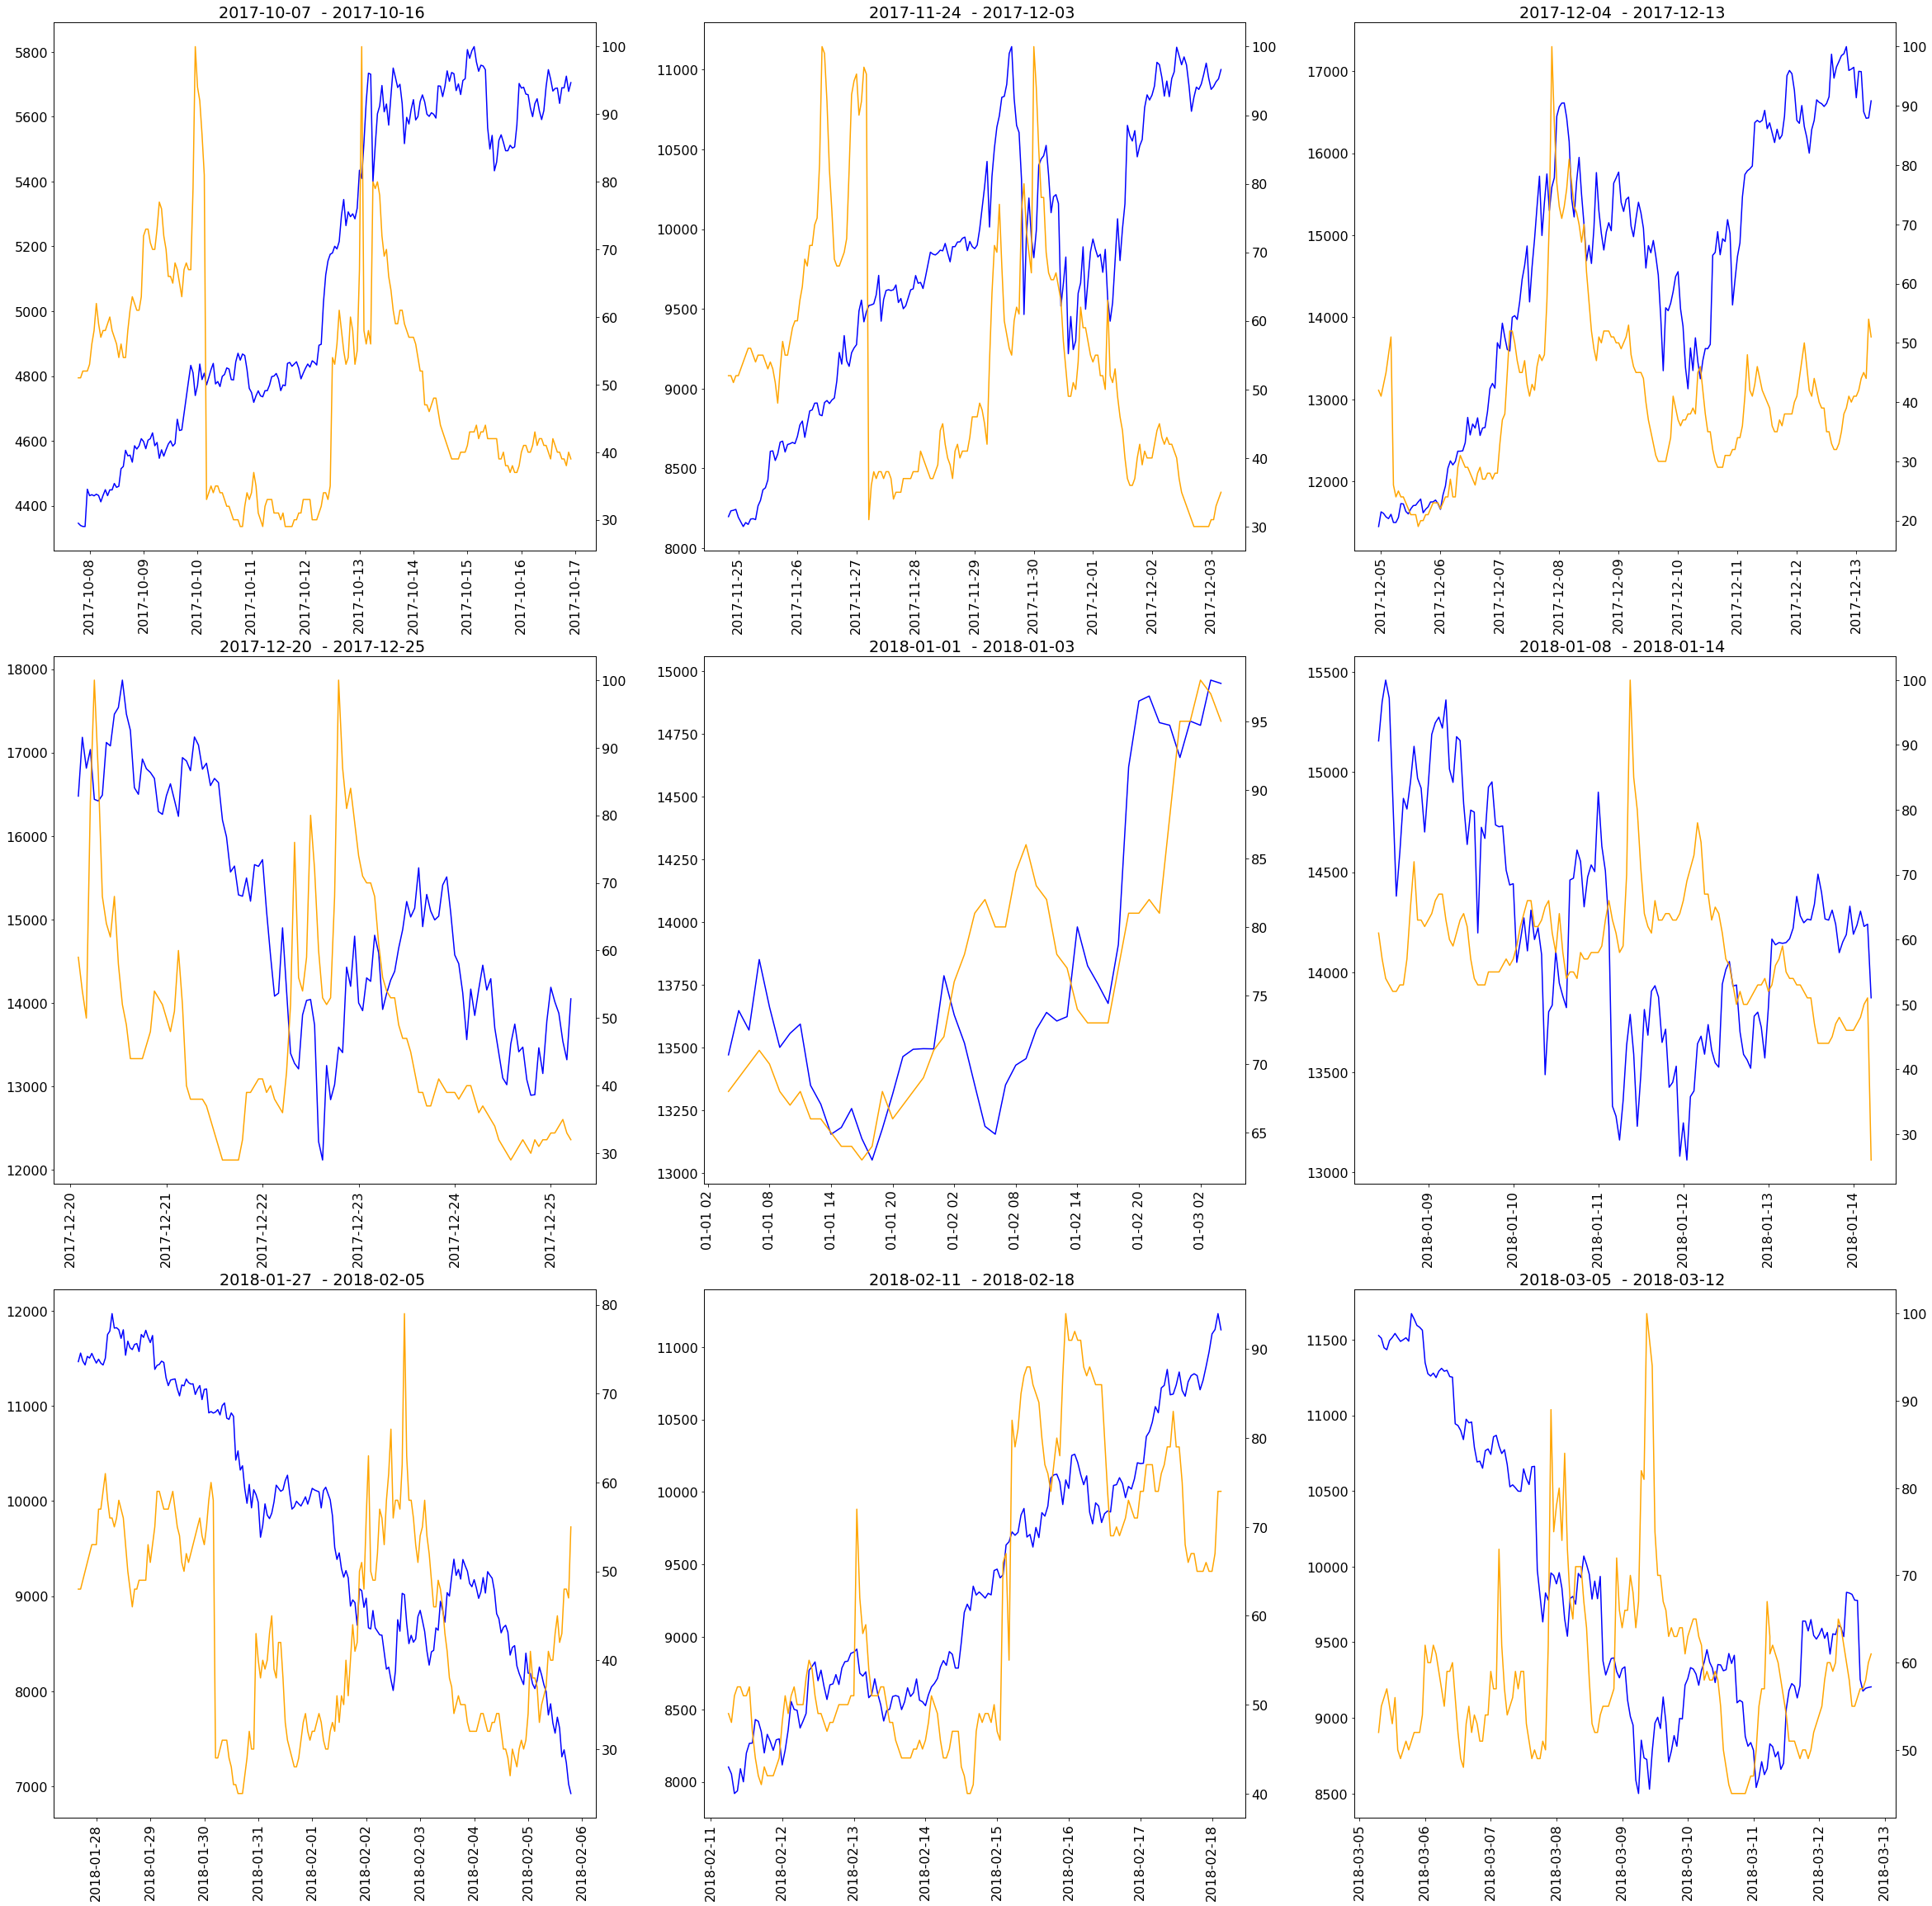

In [22]:
fig2, axes2 = plt.subplots(nrows=3, ncols=3, figsize=(40,40), sharex=False, sharey=False)

#for i, anomaly in enumerate(anomalies):
for i, ax in enumerate(axes2.flatten()):    
    time_period = anomalies[i].get_time_window()
    start_timestamp = time_period[0]
    end_timestamp = time_period[1] 
        
    in_range_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly["Timestamp"] <= end_timestamp) ]
    #display(in_range_df)
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin"], color='orange' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(in_range_df["Date(UTC)"].iloc[-1])[:-8] )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
fig.tight_layout()
fig.subplots_adjust(hspace=2)
plt.show();

# Blue is Price, Orange is Trend. 
# TODO: NEED TO UPDATE TO CHANGE THE FOR LOOP TO NUMBER OF ANOMALIES!!!!!!!

In [ ]:
# to do: find out when google trend data had anomalies 